# Set up

In [1]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

from pathlib import Path
import re
import pickle
import seaborn as sns
from pandas.plotting import parallel_coordinates

# Data

In [2]:
def extract_data(csv_path, col_name = "estimated_params"):
    df = pd.read_csv(csv_path)
    estimated_params_list = df[col_name].apply(ast.literal_eval).tolist()
    return np.array(estimated_params_list)

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [ ]:
L_GP_params = extract_data("PlotData/L.GP_21_result.csv")

L_DKGP_params = extract_data("PlotData/L.DKGP_21_result.csv")

L_MGP_params = extract_data("PlotData/L.MGP_21_result.csv")

L_DKMGP_params = extract_data("PlotData/L.DKMGP_21_result.csv")

MVGP_params = extract_data("PlotData/MVGP_21_result.csv")

DGP_params = extract_data("PlotData/DGP_21_point_result.csv")

DNN_params = extract_data("PlotData/DNN_21_result.csv")

# Plots

In [4]:
base_dir = "PlotData"

model_files = {
    "L_GP": "L.GP_21_result.csv",
    "L_DKGP": "L.DKGP_21_result.csv", 
    "L_MGP": "L.MGP_21_result.csv",
    "L_DKMGP": "L.DKMGP_21_result.csv",
    "MVGP": "MVGP_21_result.csv",
    "DGP": "DGP_21_point_result.csv",
    "DNN": "DNN_21_result.csv"
}

## pre

In [5]:
mse_results = {}
for model, filename in model_files.items():
    est = extract_data(os.path.join(base_dir, filename), col_name = 'test_preds')

    mse_results[model] = np.mean((est - Y_test_21) ** 2)



mse_df = pd.DataFrame.from_dict(mse_results, orient='index', columns=['MSE'])
mse_df.index.name = 'Model'
mse_df = mse_df.reset_index()


print(mse_df)


     Model       MSE
0     L_GP  0.003194
1   L_DKGP  0.005025
2    L_MGP  0.009780
3  L_DKMGP  0.001409
4     MVGP  0.000643
5      DGP  0.004502
6      DNN  0.003068


## Single vs. Multi

In [6]:
mse_dict = {}
for model, filename in model_files.items():
    est = extract_data(os.path.join(base_dir, filename))

    mse_per_row = np.mean((est - X_test) ** 2, axis=1)
    mse_dict[model] = mse_per_row



mse_df = pd.DataFrame(mse_dict)


C:\Users\r4718\AppData\Local\Temp\ipykernel_29688\2976613020.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)


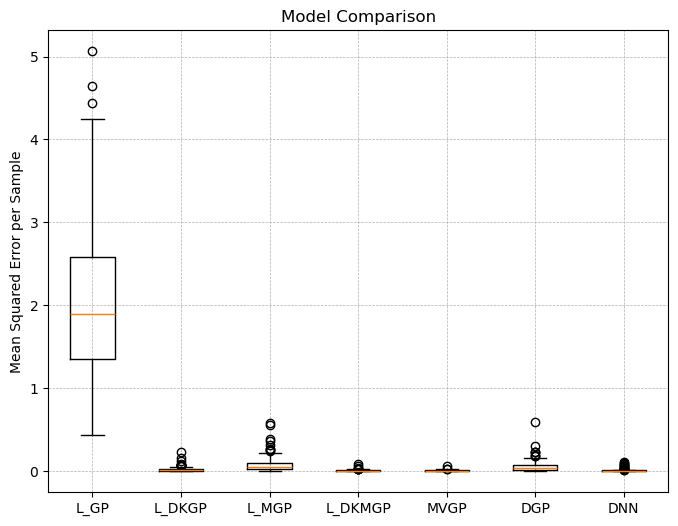

In [7]:
plt.figure(figsize=(8, 6))
plt.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
plt.ylabel("Mean Squared Error per Sample")
plt.title("Model Comparison")
plt.grid(True, linestyle='--', linewidth=0.5)
# plt.ylim(0, 0.5)
plt.show()

C:\Users\r4718\AppData\Local\Temp\ipykernel_29688\2370550041.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)


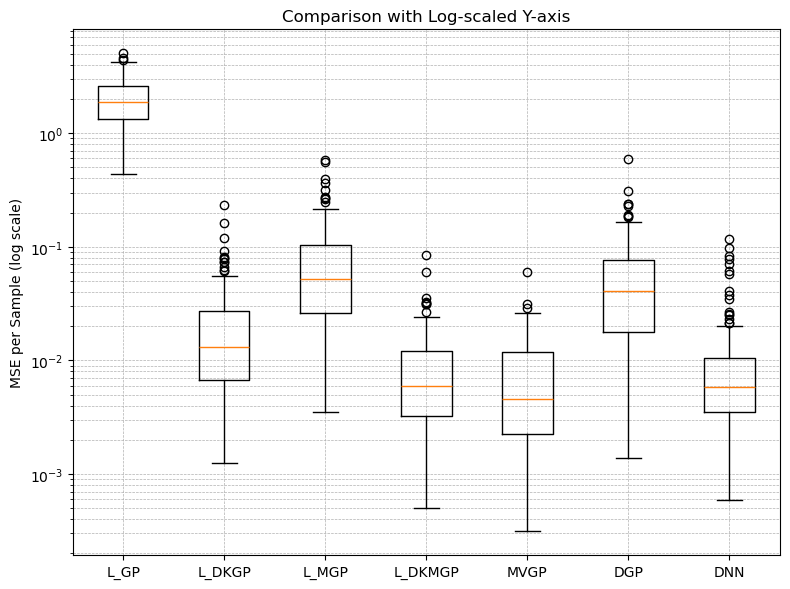

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
ax.set_yscale('log')
ax.set_ylabel("MSE per Sample (log scale)")
ax.set_title("Comparison with Log-scaled Y-axis")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Local vs. Global

In [14]:
ROOT = Path("PlotData")


PKL_PATTERN = re.compile(r"result_(\d+)\.pkl", re.IGNORECASE)

true_params = X_test

have_true = True


Scanning L.DKMGP_21_mcmc_result …
Scanning L.MGP_21_mcmc_result …
Scanning MVGP_21_mcmc_result …

Loaded 360 runs across 3 models.
Data table written → all_runs.csv


C:\Users\r4718\AppData\Local\Temp\ipykernel_16820\2384594239.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="model", y="rmse", palette="Set2", showfliers=False)
C:\Users\r4718\AppData\Local\Temp\ipykernel_16820\2384594239.py:127: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\r4718\AppData\Local\Temp\ipykernel_16820\2384594239.py:128: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(ROOT / "error_violin.png", dpi=150)


Figures saved: rmse_box.png, parallel_coords.png, pca_scatter.png, error_violin.png


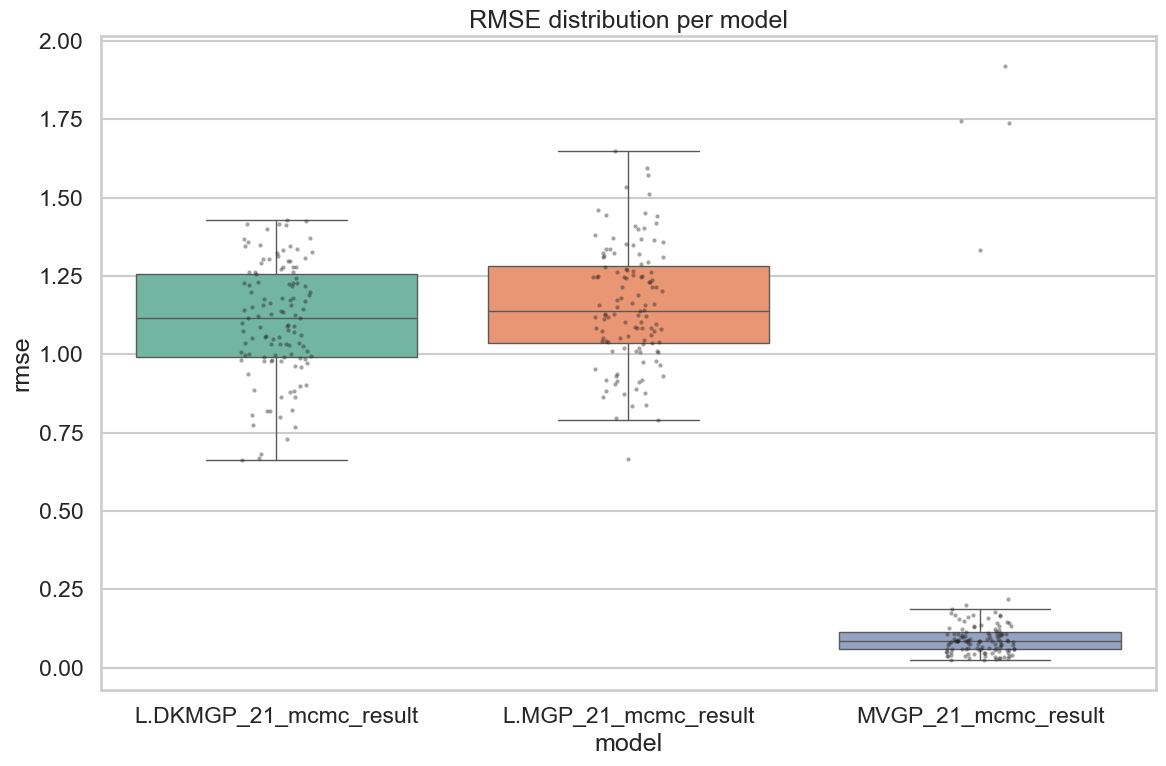

d:\anaconda3\envs\FGPyT\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


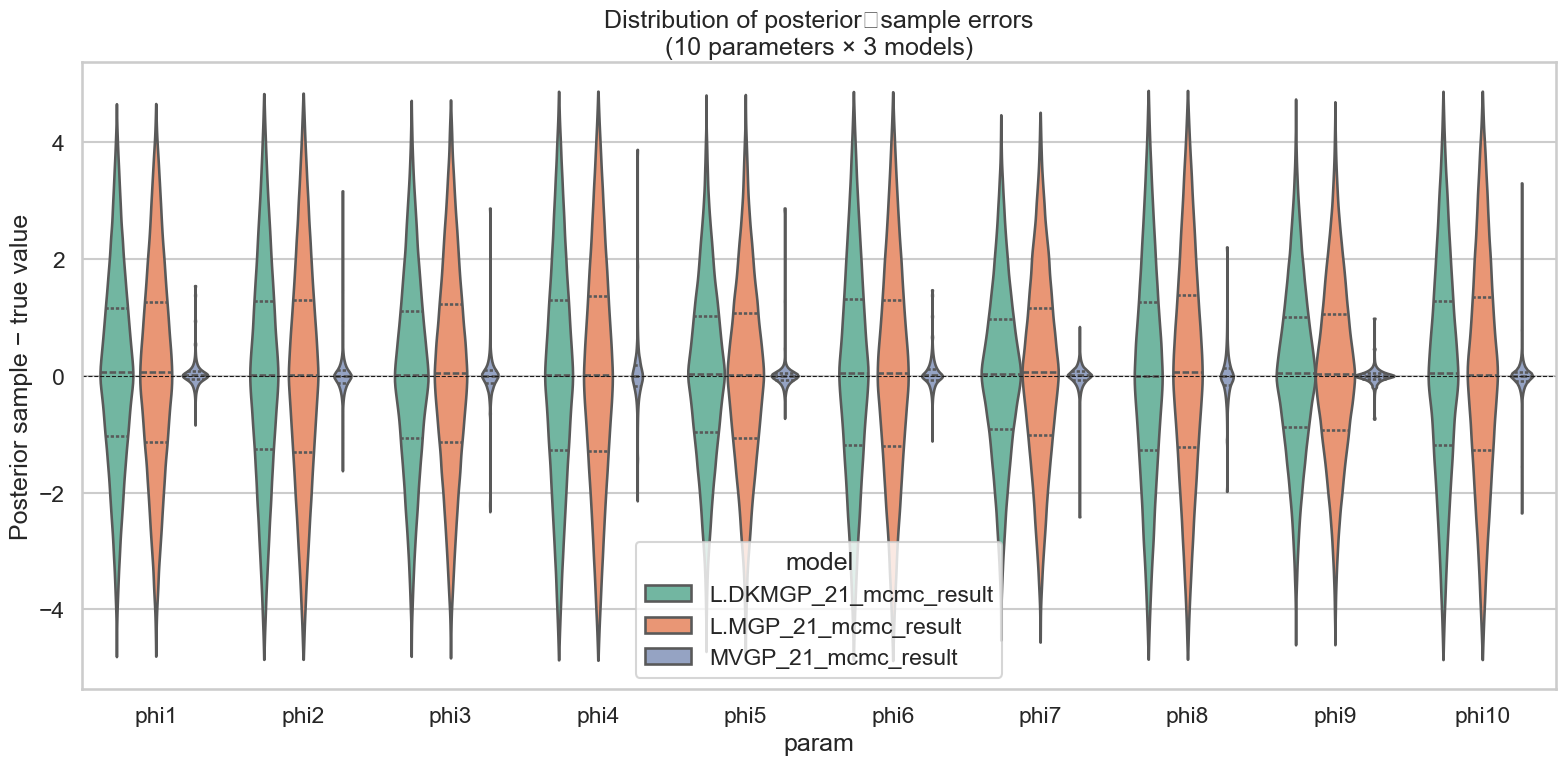

In [16]:
rows: list[dict[str, float]] = []
error_records: list[pd.DataFrame] = []  # for per‑sample error distributions

for model_dir in sorted(ROOT.iterdir()):
    if not model_dir.is_dir():
        continue

    model_name = model_dir.name
    print(f"Scanning {model_name} …")

    pkl_files = sorted(
        (p for p in model_dir.glob("result_*.pkl") if PKL_PATTERN.match(p.name)),
        key=lambda p: int(PKL_PATTERN.search(p.name).group(1))
    )

    for pkl_path in pkl_files:
        run_id = int(PKL_PATTERN.search(pkl_path.name).group(1))

        with pkl_path.open("rb") as fh:
            posterior_dict = pickle.load(fh)

        # (n_draws, 10)
        samples = np.column_stack([
            np.asarray(posterior_dict[f"param_{i}"], dtype=float).ravel()
            for i in range(10)
        ])

        theta_star = true_params[run_id - 1]

        # ── 2.1  Per‑run metrics ──────────────────────────────────────────
        post_mean = samples.mean(axis=0)
        rmse = float(np.sqrt(((post_mean - theta_star) ** 2).mean())) if have_true else np.nan

        lo, hi = np.percentile(samples, [2.5, 97.5], axis=0)
        cover95 = float(((theta_star >= lo) & (theta_star <= hi)).mean()) if have_true else np.nan

        mean_post_sd = float(samples.std(axis=0).mean())

        rows.append({
            "model": model_name,
            "run": run_id,
            "rmse": rmse,
            "cover95": cover95,
            "post_sd": mean_post_sd,
            **{f"phi{i+1}": float(theta_star[i]) for i in range(10)},
        })

        # ── 2.2  Collect per‑sample error for NEW violin plot ─────────────
        if have_true:
            err = samples - theta_star  # shape (n_draws,10)
            df_err = pd.DataFrame(err, columns=[f"phi{i+1}" for i in range(10)])
            df_err = df_err.melt(var_name="param", value_name="error")
            df_err.insert(0, "model", model_name)
            error_records.append(df_err)

print(f"\nLoaded {len(rows)} runs across {len(rows)//120 if rows else 0} models.")

# ------------------------------------------------------------
# 3  DATAFRAME & CSV OUTPUT
# ------------------------------------------------------------

df = pd.DataFrame(rows).sort_values(["model", "run"])
(df if have_true else df.drop(columns=["rmse", "cover95"]))\
    .to_csv(ROOT / "all_runs.csv", index=False)
print("Data table written → all_runs.csv")

# ------------------------------------------------------------
# 4  VISUALISATIONS
# ------------------------------------------------------------

sns.set_theme(style="whitegrid", context="talk")

if have_true:
    # 4.1  RMSE distribution per model
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x="model", y="rmse", palette="Set2", showfliers=False)
    sns.stripplot(data=df, x="model", y="rmse", color="k", size=3, alpha=0.4)
    plt.title("RMSE distribution per model")
    plt.tight_layout()
    plt.savefig(ROOT / "rmse_box.png", dpi=150)

# # 4.2  Parallel‑coordinates (parameters + scaled RMSE if available)
# sc_df = df.copy()
# scale_cols = [f"phi{i}" for i in range(1, 11)] + (["rmse"] if have_true else [])
# for c in scale_cols:
#     span = sc_df[c].max() - sc_df[c].min()
#     sc_df[c] = (sc_df[c] - sc_df[c].min()) / (span + 1e-12)

# plt.figure(figsize=(12, 6))
# parallel_coordinates(
#     sc_df[["model", *scale_cols]],
#     class_column="model", alpha=0.3, linewidth=0.8
# )
# plt.xticks(rotation=45)
# plt.title("Parallel‑coordinates: 10‑D true parameters" + (" + scaled RMSE" if have_true else ""))
# plt.tight_layout()
# plt.savefig(ROOT / "parallel_coords.png", dpi=150)

# # 4.3  PCA scatter (point size ∝ RMSE when available)
# feat_cols = [f"phi{i}" for i in range(1, 11)]
# pca = PCA(n_components=2).fit(df[feat_cols])
# df["PC1"], df["PC2"] = pca.transform(df[feat_cols]).T
# size = 40 + 260 * (df["rmse"] - df["rmse"].min()) / (df["rmse"].max() - df["rmse"].min() + 1e-12) if have_true else 60

# plt.figure(figsize=(6, 5))
# sns.scatterplot(
#     data=df, x="PC1", y="PC2", hue="model", size=size,
#     palette="Set2", sizes=(40, 300) if have_true else None,
#     alpha=0.8, edgecolor="k", legend="brief"
# )
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
# plt.title("PCA of true parameters" + ("\n(point size ∝ RMSE)" if have_true else ""))
# plt.tight_layout()
# plt.savefig(ROOT / "pca_scatter.png", dpi=150)

# 4.4  NEW: Violin plot of posterior‑sample errors per parameter × model
if have_true and error_records:
    err_df = pd.concat(error_records, ignore_index=True)

    plt.figure(figsize=(16, 8))
    sns.violinplot(data=err_df, x="param", y="error", hue="model",
                   palette="Set2", split=False, cut=0, inner="quartile")
    plt.axhline(0, color="k", lw=.8, ls="--")
    plt.ylabel("Posterior sample − true value")
    plt.title("Distribution of posterior‑sample errors\n(10 parameters × 3 models)")
    plt.tight_layout()
    plt.savefig(ROOT / "error_violin.png", dpi=150)

print("Figures saved: rmse_box.png, parallel_coords.png, pca_scatter.png" + (", error_violin.png" if have_true else ""))

In [ ]:
error_records  